<a href="https://colab.research.google.com/github/smitaforward/Data_Science/blob/master/Amazon_tensorflow2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow-gpu==2.0.0-alpha0
# !pip install tensorflow==2.0.0-alpha0

    100% |████████████████████████████████| 332.1MB 57kB/s 
    100% |████████████████████████████████| 61kB 21.2MB/s 
    100% |████████████████████████████████| 419kB 12.0MB/s 
    100% |████████████████████████████████| 3.0MB 7.0MB/s 


In [2]:
import tensorflow as tf
print(tf.__version__)

2.0.0-alpha0


In [0]:
from tensorflow import keras
import numpy as np
import pandas as pd

# Amazon comments

In [0]:
 data_path = "https://s3.amazonaws.com/tomk/h2o-world/megan/AmazonReviews.csv"
data = pd.read_csv(data_path)

In [13]:
data.head()

,ProductId,UserId,Summary,Score,HelpfulnessDenominator,Id,ProfileName,HelpfulnessNumerator,Time,Text
0,B00141QYSQ,A1YS02UZZGRDCT,Do Not Buy,1,2,41471,Evan Eberhardt,2,1348358400,These are made in China (do not buy ANY pet fo...
1,B0089SPEO2,A3JOYNYL458QHP,Less lemon and less zing,3,0,28582,coleridge,0,1323907200,"Everything is ok, except it just isn't as good..."
2,B001PMCDK2,A14TTMM0Z03Y2W,my cat goes crazy for these!,5,0,389965,Lindsay S. Bradford,0,1310601600,Best cat treat ever. There isn't anything comp...
3,B002Q8JOSI,A17UQD2RSSQH5X,My dogs tell me these treats are YUMMY,5,1,212536,in the dark,1,1316131200,My two Corgis were thoroughly spoiled by my la...
4,B00176G870,A2F2MZW8EOGH5J,Yummy to the tummy,5,0,115971,"daemoncycler ""When you arrive at a fork in th...",0,1334793600,We used to have drive down to the specialty pe...


# Quick Example About IMDB

In [4]:
imdb = keras.datasets.imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words = 10000)

17465344/17464789 [==============================] - 0s 0us/step


Explore the data

In [5]:
print(f'Training entries:{len(train_data)}, labels: {len(train_labels)}')

Training entries:25000, labels: 25000


In [6]:
print(train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


In [7]:
print(len(train_data[0]), len(train_data[1]))

218 189


In [0]:
# A dictionary mapping words to an integer index
word_index = imdb.get_word_index()

In [13]:
# The first indices are reserved
word_index = {k:(v+3) for k,v in word_index.items()} 
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])
  
decode_review(train_data[0])

"<START> in with i like horrible business chinese charm would killer waited which explosion ? going at fun ? film make like lame character has novel <UNK> a all final sense ? real ? find character nothing <UNK> second perhaps they ? find valuable cover this city an br overall ? horror has i ? should shop was in with ? delightful 00 despite ? with their people is i like horrible an well it br garbage ? with this genre this is i taken that <UNK> ? she sex is and house and after ? ? product bud i final which returned be ? does is i an annoying ? film where if at man it's film sent be ? with is comedy you than some ? in perfect i get <UNK> and ? think plot windows it fun ? <UNK> the lou ? sequence at their like horrible wanted on getting night just the ? <UNK> rich br any other ? couple it someone then he decade more on why ? can't ajay that ? family with for still wanted on final ? such his lindsay that if at you interesting how film any ? family would i an g other is i once ? i boot seen

Prep the data

In [0]:
train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=256)

test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                       value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=256)

In [16]:
print(len(train_data[0]), len(train_data[1]))

256 256


In [17]:
print(train_data[0])

[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   18    4  226   22   21  134  476
   26  480    5  144   30 5535   18   51   36   28  224   92   25  104
    4 

## Toy Model

Build the model

In [34]:
# input shape is the vocabulary count used for the movie reviews (10,000 words)
vocab_size = 10000

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 16))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d_2 ( (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Train the model

In [0]:
# create validation set
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

In [21]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1) # means print out the training info

Train on 15000 samples, validate on 10000 samples
Epoch 1/40
15000/15000 [==============================] - 1s 93us/sample - loss: 0.6914 - accuracy: 0.6069 - val_loss: 0.6884 - val_accuracy: 0.7118
Epoch 2/40
15000/15000 [==============================] - 1s 70us/sample - loss: 0.6832 - accuracy: 0.7348 - val_loss: 0.6774 - val_accuracy: 0.7399
Epoch 3/40
15000/15000 [==============================] - 1s 67us/sample - loss: 0.6658 - accuracy: 0.7581 - val_loss: 0.6558 - val_accuracy: 0.7565
Epoch 4/40
15000/15000 [==============================] - 1s 68us/sample - loss: 0.6366 - accuracy: 0.7686 - val_loss: 0.6231 - val_accuracy: 0.7608
Epoch 5/40
15000/15000 [==============================] - 1s 81us/sample - loss: 0.5956 - accuracy: 0.7976 - val_loss: 0.5816 - val_accuracy: 0.7912
Epoch 6/40
15000/15000 [==============================] - 1s 68us/sample - loss: 0.5468 - accuracy: 0.8218 - val_loss: 0.5364 - val_accuracy: 0.8110
Epoch 7/40
15000/15000 [==============================] 

Evaluate the model

In [22]:
results = model.evaluate(test_data, test_labels)

print(results)

25000/25000 [==============================] - 1s 40us/sample - loss: 0.3416 - accuracy: 0.8694
[0.3415939032173157, 0.86944]


Graph of accuracy and loss overtime

In [23]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

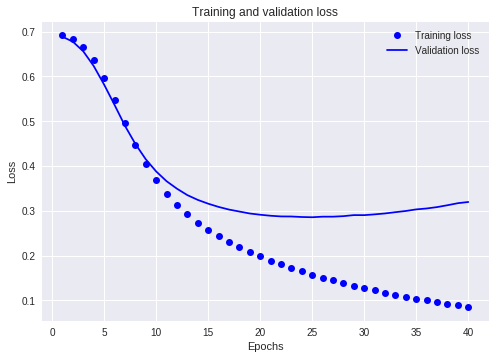

In [24]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

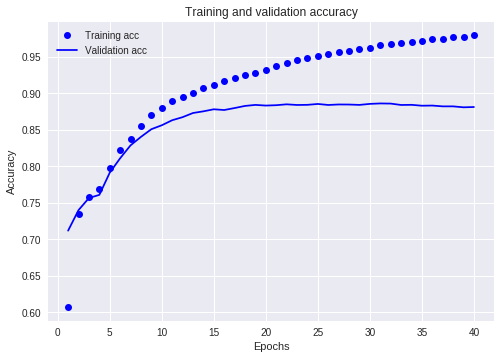

In [25]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## seqCNN

Build the model

In [0]:
def _get_last_layer_units_and_activation(num_classes):
    """Gets the # units and activation function for the last network layer.

    # Arguments
        num_classes: int, number of classes.

    # Returns
        units, activation values.
    """
    if num_classes == 2:
        activation = 'sigmoid'
        units = 1
    else:
        activation = 'softmax'
        units = num_classes
    return units, activation

In [0]:
from tensorflow.keras import models
from tensorflow.keras import initializers
from tensorflow.keras import regularizers

from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import SeparableConv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import GlobalAveragePooling1D

def sepcnn_model(blocks,
                 filters,
                 kernel_size,
                 embedding_dim,
                 dropout_rate,
                 pool_size,
                 input_shape,
                 num_classes,
                 num_features,
                 use_pretrained_embedding=False,
                 is_embedding_trainable=False,
                 embedding_matrix=None):
    """Creates an instance of a separable CNN model.

    # Arguments
        blocks: int, number of pairs of sepCNN and pooling blocks in the model.
        filters: int, output dimension of the layers.
        kernel_size: int, length of the convolution window.
        embedding_dim: int, dimension of the embedding vectors.
        dropout_rate: float, percentage of input to drop at Dropout layers.
        pool_size: int, factor by which to downscale input at MaxPooling layer.
        input_shape: tuple, shape of input to the model.
        num_classes: int, number of output classes.
        num_features: int, number of words (embedding input dimension).
        use_pretrained_embedding: bool, true if pre-trained embedding is on.
        is_embedding_trainable: bool, true if embedding layer is trainable.
        embedding_matrix: dict, dictionary with embedding coefficients.

    # Returns
        A sepCNN model instance.
    """
    op_units, op_activation = _get_last_layer_units_and_activation(num_classes)
    model = models.Sequential()

    # Add embedding layer. If pre-trained embedding is used add weights to the
    # embeddings layer and set trainable to input is_embedding_trainable flag.
    if use_pretrained_embedding:
        model.add(Embedding(input_dim=num_features,
                            output_dim=embedding_dim,
                            input_length=input_shape[0],
                            weights=[embedding_matrix],
                            trainable=is_embedding_trainable))
    else:
      model.add(Embedding(input_dim=num_features, 
                          output_dim=embedding_dim))
      
#         model.add(Embedding(input_dim=num_features,
#                             output_dim=embedding_dim,
#                             input_length=input_shape[0]))



    for _ in range(blocks-1):
        model.add(Dropout(rate=dropout_rate))
        model.add(SeparableConv1D(filters=filters,
                                  kernel_size=kernel_size,
                                  activation='relu',
                                  bias_initializer='random_uniform',
                                  depthwise_initializer='random_uniform',
                                  padding='same'))
        model.add(SeparableConv1D(filters=filters,
                                  kernel_size=kernel_size,
                                  activation='relu',
                                  bias_initializer='random_uniform',
                                  depthwise_initializer='random_uniform',
                                  padding='same'))
        model.add(MaxPooling1D(pool_size=pool_size))
#       model.add(Dropout(rate=dropout_rate))
      

    model.add(SeparableConv1D(filters=filters * 2,
                              kernel_size=kernel_size,
                              activation='relu',
                              bias_initializer='random_uniform',
                              depthwise_initializer='random_uniform',
                              padding='same'))
    model.add(SeparableConv1D(filters=filters * 2,
                              kernel_size=kernel_size,
                              activation='relu',
                              bias_initializer='random_uniform',
                              depthwise_initializer='random_uniform',
                              padding='same'))
    model.add(GlobalAveragePooling1D())
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(op_units, activation=op_activation))
    return model

In [0]:
blocks=1
filters=64
kernel_size=3
embedding_dim=200
dropout_rate=0.2
pool_size=3

input_shape=partial_x_train.shape[1:]
num_classes=2
num_features = min(len(word_index) + 1, vocab_size)

In [0]:
model = sepcnn_model(blocks=blocks,
                                     filters=filters,
                                     kernel_size=kernel_size,
                                     embedding_dim=embedding_dim,
                                     dropout_rate=dropout_rate,
                                     pool_size=pool_size,
                                     input_shape=input_shape,
                                     num_classes=num_classes,
                                     num_features=num_features,
                        is_embedding_trainable = True)

In [68]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, None, 200)         2000000   
_________________________________________________________________
separable_conv1d_18 (Separab (None, None, 128)         26328     
_________________________________________________________________
separable_conv1d_19 (Separab (None, None, 128)         16896     
_________________________________________________________________
global_average_pooling1d_8 ( (None, 128)               0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 129       
Total params: 2,043,353
Trainable params: 2,043,353
Non-trainable params: 0
____________________________________________

Train the model

In [0]:
# Compile model with learning parameters.
learning_rate=1e-3
epochs=100
batch_size=128
loss = 'binary_crossentropy'
optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
model.compile(optimizer=optimizer, loss=loss, metrics=['acc'])

callbacks = [keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=2)]

In [0]:
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

In [72]:
history = model.fit(
            partial_x_train,
            partial_y_train,
            epochs=epochs,
            callbacks=callbacks,
            validation_data=(x_val, y_val),
            verbose=1,  # Logs once per epoch.
            batch_size=batch_size)

Train on 15000 samples, validate on 10000 samples
Epoch 1/100
15000/15000 [==============================] - 45s 3ms/sample - loss: 0.6933 - acc: 0.5007 - val_loss: 0.6933 - val_acc: 0.4947
Epoch 2/100
15000/15000 [==============================] - 45s 3ms/sample - loss: 0.6730 - acc: 0.5595 - val_loss: 0.5338 - val_acc: 0.7498
Epoch 3/100
15000/15000 [==============================] - 45s 3ms/sample - loss: 0.3540 - acc: 0.8497 - val_loss: 0.3019 - val_acc: 0.8777
Epoch 4/100
15000/15000 [==============================] - 45s 3ms/sample - loss: 0.2185 - acc: 0.9175 - val_loss: 0.2878 - val_acc: 0.8856
Epoch 5/100
15000/15000 [==============================] - 45s 3ms/sample - loss: 0.1573 - acc: 0.9432 - val_loss: 0.3040 - val_acc: 0.8863
Epoch 6/100
15000/15000 [==============================] - 45s 3ms/sample - loss: 0.1141 - acc: 0.9584 - val_loss: 0.3377 - val_acc: 0.8840


Evaluate the model

In [73]:
results = model.evaluate(test_data, test_labels)

25000/25000 [==============================] - 22s 870us/sample - loss: 0.3644 - acc: 0.8692


In [74]:
print(results)

[0.364426405954361, 0.86924]


In [0]:
"""Module to train sequence model.
Vectorizes training and validation texts into sequences and uses that for
training a sequence model - a sepCNN model. We use sequence model for text
classification when the ratio of number of samples to number of words per
sample for the given dataset is very large (>~15K).
"""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import time


FLAGS = None

# Limit on the number of features. We use the top 10K features.
TOP_K = 10000

def get_num_classes(labels):
    """Gets the total number of classes.
    # Arguments
        labels: list, label values.
            There should be at lease one sample for values in the
            range (0, num_classes -1)
    # Returns
        int, total number of classes.
    # Raises
        ValueError: if any label value in the range(0, num_classes - 1)
            is missing or if number of classes is <= 1.
    """
    num_classes = max(labels) + 1
    missing_classes = [i for i in range(num_classes) if i not in labels]
    if len(missing_classes):
        raise ValueError('Missing samples with label value(s) '
                         '{missing_classes}. Please make sure you have '
                         'at least one sample for every label value '
                         'in the range(0, {max_class})'.format(
                            missing_classes=missing_classes,
                            max_class=num_classes - 1))

    if num_classes <= 1:
        raise ValueError('Invalid number of labels: {num_classes}.'
                         'Please make sure there are at least two classes '
                         'of samples'.format(num_classes=num_classes))
    return num_classes



def train_sequence_model(data,word_index,
                         learning_rate=1e-3,
                         epochs=100,
                         batch_size=128,
                         blocks=2,
                         filters=64,
                         dropout_rate=0.2,
                         embedding_dim=200,
                         kernel_size=3,
                         pool_size=3):
    """Trains sequence model on the given dataset.
    # Arguments
        data: tuples of training and test data(not text) and labels.
        word_index:
        learning_rate: float, learning rate for training model.
        epochs: int, number of epochs.
        batch_size: int, number of samples per batch.
        blocks: int, number of pairs of sepCNN and pooling blocks in the model.
        filters: int, output dimension of sepCNN layers in the model.
        dropout_rate: float: percentage of input to drop at Dropout layers.
        embedding_dim: int, dimension of the embedding vectors.
        kernel_size: int, length of the convolution window.
        pool_size: int, factor by which to downscale input at MaxPooling layer.
    # Raises
        ValueError: If validation data has label values which were not seen
            in the training data.
    """
    # Get the data.
    # (train_texts, train_labels), (val_texts, val_labels) = data
    
    (train_data, train_labels), (test_data, test_labels) = data
    
    train_data = tf.keras.preprocessing.sequence.pad_sequences(train_data,
                                                        #value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=256)
    test_data = tf.keras.preprocessing.sequence.pad_sequences(test_data,
                                                       #value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=256)
    x_train = train_data[:15000]
    y_train = train_labels[:15000]
    
    x_val = train_data[15000:]
    y_val = train_labels[15000:]

    # Verify that validation labels are in the same range as training labels.
    num_classes = get_num_classes(train_labels)
    unexpected_labels = [v for v in test_labels if v not in range(num_classes)]
    if len(unexpected_labels):
        raise ValueError('Unexpected label values found in the validation set:'
                         ' {unexpected_labels}. Please make sure that the '
                         'labels in the validation set are in the same range '
                         'as training labels.'.format(
                             unexpected_labels=unexpected_labels))

    # Vectorize texts.
#     x_train, x_val, word_index = vectorize_data.sequence_vectorize(
#             train_texts, val_texts)
    word_index = word_index

    # Number of features will be the embedding input dimension. Add 1 for the
    # reserved index 0.
    num_features = min(len(word_index) + 1, TOP_K)

    # Create model instance.
    model = sepcnn_model(blocks=blocks,
                                     filters=filters,
                                     kernel_size=kernel_size,
                                     embedding_dim=embedding_dim,
                                     dropout_rate=dropout_rate,
                                     pool_size=pool_size,
                                     input_shape=x_train.shape[1:],
                                     num_classes=num_classes,
                                     num_features=num_features,
                        is_embedding_trainable = True)

    # Compile model with learning parameters.
    if num_classes == 2:
        loss = 'binary_crossentropy'
    else:
        loss = 'sparse_categorical_crossentropy'
    optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
    model.compile(optimizer=optimizer, loss=loss, metrics=['acc'])

    # Create callback for early stopping on validation loss. If the loss does
    # not decrease in two consecutive tries, stop training.
    callbacks = [tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=2)]

    # Train and validate model.
    history = model.fit(
            x_train,
            y_train,
            epochs=epochs,
            callbacks=callbacks,
            validation_data=(x_val, y_val),
            verbose=2,  # Logs once per epoch.
            batch_size=batch_size)

    # Print results.
    history = history.history
    print('Validation accuracy: {acc}, loss: {loss}'.format(
            acc=history['val_acc'][-1], loss=history['val_loss'][-1]))

    # Save model.
    model.save('imdb_sepcnn_model.h5')
    return history['val_acc'][-1], history['val_loss'][-1]

In [11]:
 # Using the IMDB movie reviews dataset to demonstrate
    # training sequence model.
    imdb = tf.keras.datasets.imdb
    data = imdb.load_data(num_words = 10000)
    word_index = imdb.get_word_index()
    train_sequence_model(data, word_index)


Train on 15000 samples, validate on 10000 samples
Epoch 1/100
 - 53s - loss: 0.6932 - acc: 0.5000 - val_loss: 0.6932 - val_acc: 0.4967
Epoch 2/100
 - 52s - loss: 0.6932 - acc: 0.4988 - val_loss: 0.6932 - val_acc: 0.4967
Epoch 3/100
 - 52s - loss: 0.6933 - acc: 0.4983 - val_loss: 0.6932 - val_acc: 0.4967
Epoch 4/100


KeyboardInterrupt: ignored